To set the scene, we are trying to find the ground state energy of a given $n$ dimensional hamiltonian $$H = \sum_{i = 1}^N \alpha_i * P_{i}$$
Where $P_{i} \in \{X, Y, Z, I\}^{\otimes n}$

We use PDS(K) to estimate the ground state energy. PDS(K) relies on calculation of $2K-1$ hamiltonian moments, $\langle H^k \rangle$, $k \in \{1,...,2K-1\}$

For large $k$, the number of terms in $H^k$ tends to blow up. Granted we have seen cases where it reaches an upper bound but this may be exceedingly large for complex Hamiltonians.

Therefore, we need some way to reduce the number of measurements. Classical Shadows is inexpensive but inaccurate whereas QWC is expensive but accurate. In order to optimally mix the two strategies, we need to find the optimal cut off point between QWC and CS.

One way to think about this is by calculate the partial derivatives of the energy estimate wrt to each pauli. For notationaly clarity, define $$d_i := \frac{\partial E}{\partial \langle P_i \rangle}$$. In our case, $E$ is a function of the $2K-1$ moments so applying the chain rule,
$$d_i = \sum_{i=1}^{2K-1} \frac{\partial E}{\partial \langle H^i \rangle} \frac{\partial \langle H^i \rangle}{\partial \langle P_i \rangle}$$
Luckily, $\frac{\partial \langle H^i \rangle}{\partial \langle P_i \rangle}$ some scalar we know, so we really just have to find a good way to calculate $\frac{\partial E}{\partial \langle H^i \rangle}$. Dr. Peng solved analytically for $\frac{\partial E}{\partial \langle H^i \rangle}$ given $\{\langle H^i \rangle | i \in \{1,...,2K-1\}\}$ however, we don't implicitly know the moments so we need some way to estimate them. In this notebook, I will discuss a few strategies for approximating $\langle H^ i \rangle$ and see how they perform in calculating the $d_i$.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from itertools import product 
import shadows
import json
import qiskit as qm
import Hamiltonians.helper as helper
import Hamiltonians.hamiltonians as ham
import numpy as np
from itertools import combinations
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

In [2]:
n_qubits = 4
K = 4

<h1> Step 1) Boilerplate Set up </h1>
The next cells are just setting up the Hamiltonian in the Pauli basis and some other typical stuff.

In [3]:
ket0 = np.array([1.,0.],dtype=complex)
ket1 = np.array([0.,1.],dtype=complex)


PauliX = np.array([[0.,1.],[1.,0]], dtype=complex)
PauliY = np.array([[0.,-1.j],[1.j,0]], dtype=complex)
PauliZ = np.array([[1.0,0.],[0.,-1.]], dtype=complex)
PauliI = np.eye(2, dtype=complex)
PauliVec = [PauliX, PauliY, PauliZ]
cz = np.eye(4)
cz[3,3] = -1
PauliDict = {"Identity": "I", "PauliX": "X", "PauliY": "Y", "PauliZ": "Z"}
PauliNumToLetter = {0: "X", 1: "Y", 2: "Z"}
PauliDict_2 = {"I": PauliI, "X": PauliX, "Y": PauliY, "Z": PauliZ}
Hadamard = (1/np.sqrt(2)) * np.array([[1,1],[1,-1]])
CNOT = np.eye(4)
CNOT[3,3]=0
CNOT[2,2] = 0 
CNOT[3,2] = 1
CNOT[2,3] = 1
thetaTest = [-2,1]
cz = np.eye(4)
cz[3,3] = -1
def RY(theta):
    '''
        matrix representation of the RY gate in the Z computational basis
    '''
    matrix = np.zeros((2,2),dtype=complex)
    matrix[0,0] = np.cos(theta/2)
    matrix[1,1] = np.cos(theta/2)
    matrix[0,1] = -np.sin(theta/2)
    matrix[1,0] =  np.sin(theta/2)
    return matrix
def RZ(theta):
    matrix = np.zeros((2,2), dtype=complex)
    matrix[0,0] = np.exp(-1.j * theta/2)
    matrix[1,1] = np.exp(1.j * theta/2)
    return matrix
def linear_hamiltonian_matrix_dict(j,u,b=1.0,n=10):
    '''
        represent our Hamiltonian as a matrix
    '''
    combos = list(combinations([int(i) for i in range(n)],2))
    H = {}
    for i in range(n-1):
        next_ = i+1

        for k in range(3):
            A = ["I" for i in range(n)]
            A[i] = PauliNumToLetter[k]
            A[next_] = PauliNumToLetter[k]
            x = j
            if(k==2):
                x = u
            H["".join(A)] = x
            
    for i in range(n):
        A = ["I" for i in range(n)]
        A[i] = "Z"
        H ["".join(A)] = b
    return H

def linear_hamiltonian_matrix(j,u,b=1.0,n=10):
    '''
        represent our Hamiltonian as a matrix
    '''
    combos = list(combinations([int(i) for i in range(n)],2))
    H = np.zeros((2**n, 2**n), dtype=complex)
    for i in range(n-1):
        next_ = i+1

        for k in range(3):
            A = [PauliI for i in range(n)]
            A[i] = PauliVec[k]
            A[next_] = PauliVec[k]
            x = j
            if(k==2):
                x = u
            add = [1]
            for qbit in range(n):
                
                add = np.kron(add, A[qbit])
            H += x*add
            
    for i in range(n):
        A = [PauliI for i in range(n)]
        A[i] = PauliZ
        add = [1]
        for qbit in range(n):
                add = np.kron(add, A[qbit])
        H += b * add
    return H

In [4]:
ham_mat = linear_hamiltonian_matrix(1,1,1,n_qubits)
ham_dict = linear_hamiltonian_matrix_dict(1,1,1,n_qubits)
ham_qm = ham.Hamiltonian(list(ham_dict.keys()), list(ham_dict.values()))

In [5]:
def circuit(theta):
    qc = qm.QuantumCircuit(n_qubits,n_qubits)
    for w in range(n_qubits-1):
        qc.h(w)
        qc.ry(theta[w], w)
    for w in range(n_qubits-1):
        qc.cnot(w, w+1)
    for w in range(n_qubits):
        qc.rz(theta[w + n_qubits], w)
    return qc

In [6]:
def circuit_numerical(theta):
    psi = np.zeros(2 ** n_qubits)
    print(2**n_qubits)
    psi[0] = 1 # initialize in |0000....000>
    for w in range(n_qubits-1):
        obs_ = [1]
        for i in range(n_qubits):
            if not i == w:
                obs_ = np.kron(obs_, PauliI)
            else:
                obs_ = np.kron(obs_, Hadamard)
        psi = obs_ @ psi 
        obs_ = [1]
        for i in range(n_qubits):
            if not i == w:
                obs_ = np.kron(obs_, PauliI)
            else:
                obs_ = np.kron(obs_, RY(theta[w]))
        psi = obs_ @ psi 
    for w in range(n_qubits-1):
        obs_ = [1]
        for i in range(n_qubits):
            if not i == w and not i == w+1:
                obs_ = np.kron(obs_, PauliI)
            elif i == w:
                obs_ = np.kron(obs_, CNOT)
            elif i == w+1:
                pass;
            
        psi = obs_ @ psi
    for w in range(n_qubits):
        obs_ = [1]
        for i in range(n_qubits):
            if not i == w:
                obs_ = np.kron(obs_, PauliI)
            else:
                obs_ = np.kron(obs_, RZ(theta[w+n_qubits]))
        psi = obs_ @ psi
    return psi

In [7]:
theta_test = np.random.randn(n_qubits * 2)
psi_numerical = circuit_numerical(theta_test)
psi_qm = circuit(theta_test)

16


In [8]:
# for this test we will do this step numerically
exact_moments = {}
exact_moments = {i: np.conjugate(psi_numerical).T @ np.linalg.matrix_power(ham_mat, i) @ psi_numerical for i in range(2*K)}

<h1> Step 2) Setup $\frac{\partial E}{\partial \langle H^i \rangle}$ calculator </h1>

The key function here is `calculate_moment_partials(moment_dict_)` which can calculate $\frac{\partial E}{\partial \langle H^i \rangle}$ (exactly) given a corresponding dictionary of Hamiltonian moments.

In [9]:
#PDS(K) workhorse 

def tildeM(e_dict, K):
    M = np.zeros((K,K), dtype=complex)
    for i in range(1,K+1):
        for j in range(1,K+1):
            M[i-1,j-1] = e_dict[int(2*K-i-j)]
    return M

def tildeY(e_dict, K):
    Y = np.zeros(K, dtype=complex)
    for i in range(1,K+1):
        Y[i-1] = e_dict[int(2*K-i)]
    return Y
def comp_energy(moments, K):
    M_ = tildeM(moments, K)
    Y_ = tildeY(moments, K)
    X_ = np.linalg.lstsq(M_, -Y_,rcond=None)[0]
    coeffs = np.ones(K+1)
    for k in range(1,K+1):
        coeffs[k] = X_[k-1].real
    return np.min(np.roots(coeffs)).real

In [10]:
# Using Dr. Peng's derivation

def dYdH(K,n):
    return np.array([1 * (n == 2*K-i) for i in range(1,K+1)])
def dMdH(K, n):
    return np.array([[1 * (n == 2*K-i-j) for i in range(1, K+1)] for j in range(1,K+1)])
def dXdH(K,n,M,X):
    dydh = dYdH(K,n)
    dmdh = dMdH(K,n)
    dXdH = np.linalg.lstsq(M, -dydh - dmdh@X, rcond=None)[0]
    return dXdH
def dEdH(E,K,n,M,Y,X):
    dxdh = dXdH(K, n, M, X)
    Evec = np.array([E ** (K-1-i) for i in range(K)])
    bottom_of_coeff = K*E**(K-1) + np.sum([(K-i)*X[i-1] * E**(K-i-1) for i in range(1,K)])
    return (-1/bottom_of_coeff) * (np.dot(Evec,dxdh))
def calculate_moment_partials(moments_dict_):
    M_est = tildeM(moments_dict_, K)
    Y_est = tildeY(moments_dict_, K)
    X_est = np.linalg.lstsq(M_est, -Y_est,rcond=None)[0]
    E = comp_energy(moments_dict_, K)
    partial_derivatives = [dEdH(E, K, i, M_est, Y_est, X_est) for i in range(1,2*K)]
    return partial_derivatives

<h1> Step 3) Calculate Pauli Partial Derivatives, $d_i$ </h1>

In this step, I build a function to calculate the pauli partial derivatives $d_i$, again given a dictionary of moments

In [11]:
def pauli_importances_from_moments(m_dict_):
    M_est_ = tildeM(m_dict_, K)
    Y_est_ = tildeY(m_dict_, K)
    X_est_ = np.linalg.lstsq(M_est_, -Y_est_,rcond=None)[0]
    E_ = comp_energy(m_dict_, K)
    m_p_ = [dEdH(E_, K, i, M_est_, Y_est_, X_est_) for i in range(1,8)]
    m_pauli_partials_ = {}
    ham_qm_powers = [ham_qm.power(i) for i in range(0,8)]
    for i in range(2*K-1): # this is poorly written and has confusing indeces
                           # but it does do the job
        letters = ham_qm_powers[i+1].letters
        coeffs = ham_qm_powers[i+1].coeffs
        for j in range(len(letters)):
            if(letters[j] in m_pauli_partials_):
                m_pauli_partials_[letters[j]] += (m_p_[i] * coeffs[j])
            else:
                m_pauli_partials_[letters[j]] = (m_p_[i] * coeffs[j])
    return m_pauli_partials_

In [12]:
pauli_importances = pauli_importances_from_moments(exact_moments)

<h1> Step 3.5) Build up numerical Comparison </h1>

This is just to verify that `calculate_moment_partials(moment_dict_)` is working as expected.

In [13]:
numerical_expectations = {} 
for word in pauli_importances:
    obs_matrix = ham.Hamiltonian([word],[1]).to_matrix()
    numerical_expectations[word] = np.conjugate(psi_numerical).T @ obs_matrix @ psi_numerical

In [14]:
def moment(n, e_dict_):
    ham_ = ham_qm.power(n)
    e = 0
    for i in range(len(ham_.letters)):
        e += ham_.coeffs[i] * e_dict_[ham_.letters[i]]
    return e

def moments_from_expectations(K, e_dict_):
    moments = {}
    moments[0] = 1
    for i in range(1, 2*K):
        moments[i] = moment(i, e_dict_)
    return moments

In [15]:
numerical_importances = {}
for word in pauli_importances:
    # estimate the derivative with finite differences (central order 4)
    delta = 0.01
    numerical_expectations_f1 = numerical_expectations.copy()
    numerical_expectations_f2 = numerical_expectations.copy()
    numerical_expectations_b1 = numerical_expectations.copy()
    numerical_expectations_b2 = numerical_expectations.copy()
    numerical_expectations_f1[word] += delta
    numerical_expectations_f2[word] += 2*delta
    numerical_expectations_b1[word] -= delta
    numerical_expectations_b2[word] -= 2*delta
    numerical_moments_f1 = moments_from_expectations(K, numerical_expectations_f1)
    numerical_moments_f2 = moments_from_expectations(K, numerical_expectations_f2)
    numerical_moments_b1 = moments_from_expectations(K, numerical_expectations_b1)
    numerical_moments_b2 = moments_from_expectations(K, numerical_expectations_b2)

    E = 0 # this doesn't actual factor in a central finite difference
    Ef1 = comp_energy(numerical_moments_f1, K)
    Ef2 = comp_energy(numerical_moments_f2, K)
    Eb1 = comp_energy(numerical_moments_b1, K)
    Eb2 = comp_energy(numerical_moments_b2, K)
    Es = np.array([Eb2, Eb1, E, Ef1, Ef2])
    numerical_importances[word] = np.dot([1/12,-2/3,0,2/3,-1/12], Es)/(delta)

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


Text(0, 0.5, '$d_i$ calculated by analytical solution')

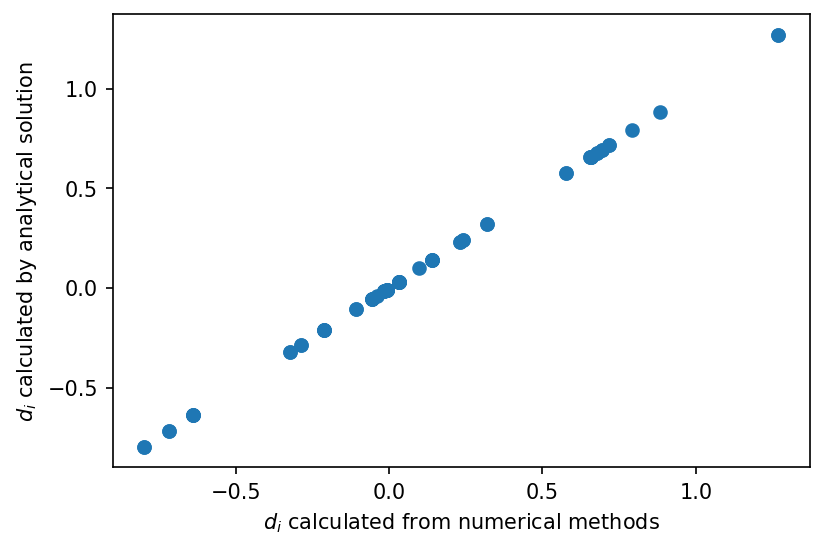

In [16]:
plt.scatter(list(numerical_importances.values()), list(pauli_importances.values()))
plt.xlabel("$d_i$ calculated from numerical methods")
plt.ylabel("$d_i$ calculated by analytical solution")

Clearly, the analytical functions are working properly and match the numerical solutions exactly. In this case, the analytical solution used the exact moments. What if we don't have any knowledge of them prior? This means we will have to try approximate methods.

<h1> Step 4) Developing a Worst Case </h1>
In the worst case scenario, we have no knowledge of the moments and they are intractable to calculate directly. We will see what happens if we use a random guess for the moments. Granted, we do know the magnitude of the moments will generally increase so it makes sense to take random numbers from increasingly large ranges for the higher order moments. So this approach could be called "random with some exponential character."

In [17]:
random_moments = {i: (np.random.randn(2**(i)))[0] for i in range(len(exact_moments))} 

In [18]:
random_importances = pauli_importances_from_moments(random_moments)

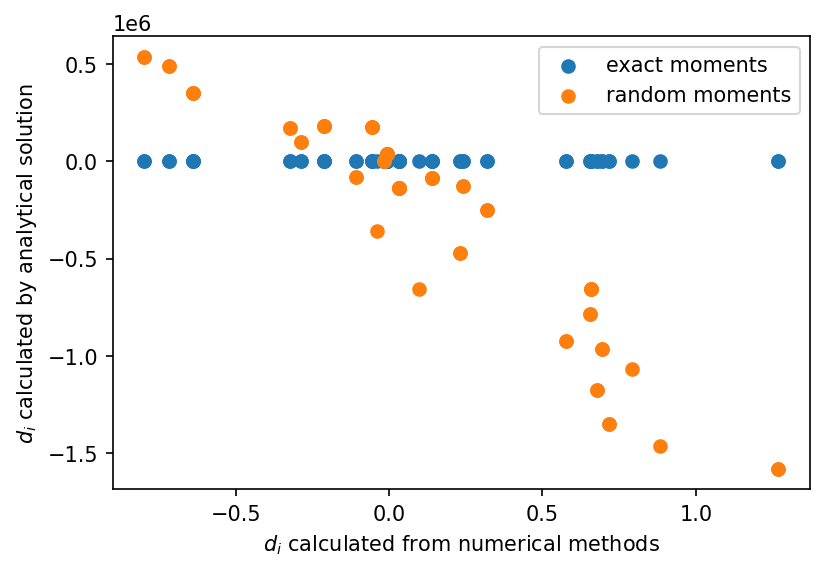

In [19]:
plt.scatter(list(numerical_importances.values()), list(pauli_importances.values()),label="exact moments")
plt.scatter(list(numerical_importances.values()), list(random_importances.values()),label="random moments")
plt.xlabel("$d_i$ calculated from numerical methods")
plt.ylabel("$d_i$ calculated by analytical solution")
plt.legend()

<h1> Step 4.5) The above plot is ugly, lets scale it! </h1>
    
Because at the end of the day all we really care about is ranking the Paulis according to the magnitude of their $d_i$, I think it is justified to apply a scaling transform to the data. The scaler I will develop now is a linear transformation with positive slope so it does not change the order of the $d_i$, but it makes it easier to compare methods. In the future, we will need a way to compat this but I think it is okay for the initial work.

In [20]:
def scale_data(data):
    data = np.array(data)
    sd = np.std(data)
    mean = np.mean(data)
    return (data-mean)/sd


In [21]:
random_importances_scaled = scale_data(list(random_importances.values()))
numerical_importances_scaled =  scale_data(list(numerical_importances.values()))
pauli_importances_scaled =  scale_data(list(pauli_importances.values()))


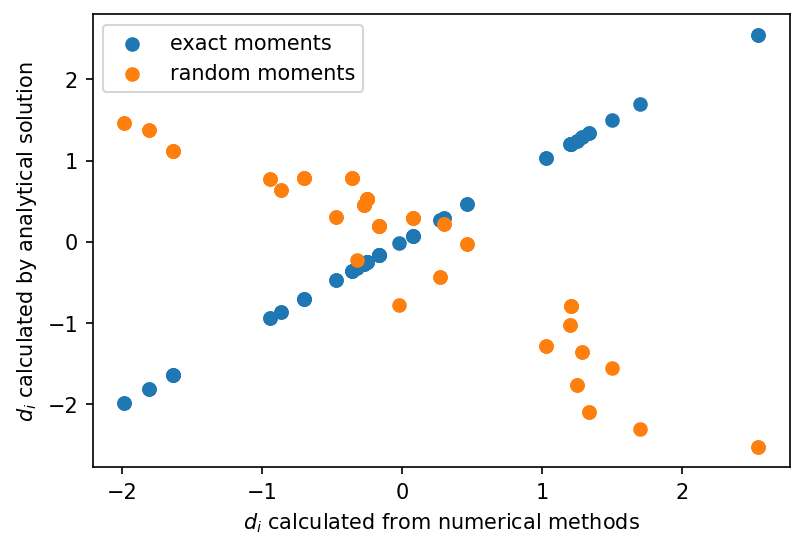

In [22]:
plt.scatter(numerical_importances_scaled, pauli_importances_scaled,label="exact moments")
plt.scatter(numerical_importances_scaled, random_importances_scaled,label="random moments")
plt.xlabel("$d_i$ calculated from numerical methods")
plt.ylabel("$d_i$ calculated by analytical solution")
plt.legend()

Much better! And let's keep a running track of the MSE,

In [23]:
def strategy_mse(scaled_data):
    return round(np.mean(np.abs(scaled_data - numerical_importances_scaled)),4)

In [24]:
strategies_mse_dict = {}
strategies_mse_dict["exact"] = strategy_mse(pauli_importances_scaled)
strategies_mse_dict["random"] = strategy_mse(random_importances_scaled)

In [25]:
strategies_mse_dict

{'exact': 0.0001, 'random': 1.5473}

<h1> Step 5) Direct Exponential Approximation </h1>
    
In this strategy, I will fit an exponential curve to the exact moments. This strategy is not robust in that it actually requires the moments in order to fit the exponential approximation. However, I think it is a good starting point to see if the moments really do have exponential character.

In my initial trials I have found that the moments oscillate sign sometimes. I will try to account for that here.

/tmp/ipykernel_396/3921541245.py:4: RuntimeWarning: overflow encountered in exp
  return a * np.exp(-b * x)
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, '$\\langle H^n \\rangle$')

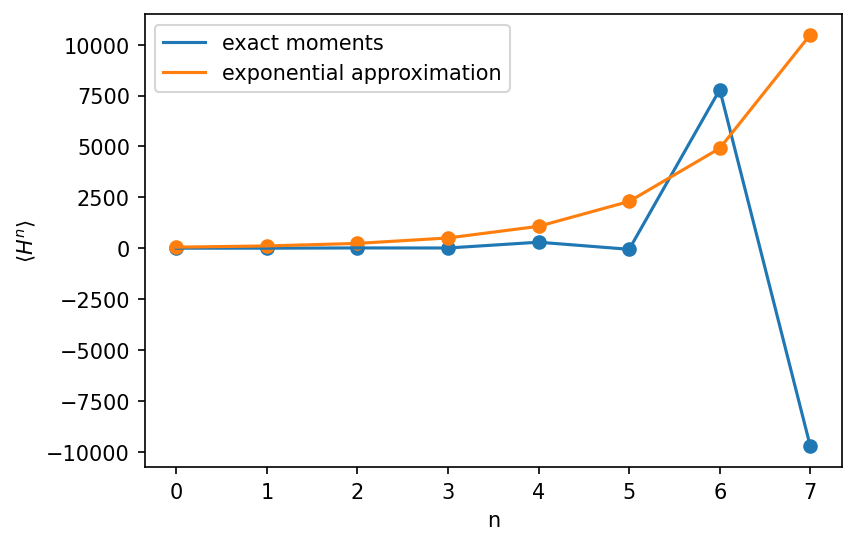

In [26]:
from scipy.optimize import curve_fit

def func(x, a, b, c, d, e):
    return a * np.exp(-b * x)
def approximate_moment(i):
    sgn = np.abs(exact_moments[3])/exact_moments[3]
    return (sgn)**i * func(i, *popt)
popt, _ = curve_fit(func, range(1,2*K), np.abs(list(exact_moments.values()))[1:]) # we know <H^0> = 1
exponential_moments = {i: approximate_moment(i) for i in range(2*K)}

plt.plot(range(2*K), exact_moments.values(),label="exact moments")
plt.scatter(range(2*K), exact_moments.values())
plt.plot(range(2*K), exponential_moments.values(), label="exponential approximation")
plt.scatter(range(2*K), exponential_moments.values())
plt.legend()
plt.xlabel("n")
plt.ylabel(r"$\langle H^n \rangle$")

It is a pretty good approximation, but does it compute the $d_i$ well?

In [27]:
exponential_importances = pauli_importances_from_moments(exponential_moments)
exponential_importances_scaled = scale_data(list(exponential_importances.values()))

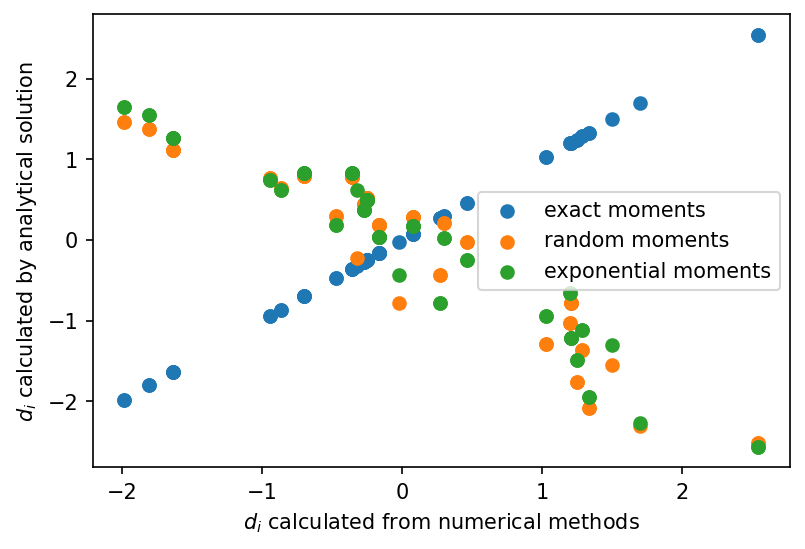

In [28]:
plt.scatter(numerical_importances_scaled, pauli_importances_scaled,label="exact moments")
plt.scatter(numerical_importances_scaled, random_importances_scaled,label="random moments")
plt.scatter(numerical_importances_scaled, exponential_importances_scaled,label="exponential moments")
plt.xlabel("$d_i$ calculated from numerical methods")
plt.ylabel("$d_i$ calculated by analytical solution")
plt.legend()

In [29]:
strategies_mse_dict["exponential"] = strategy_mse(exponential_importances_scaled)

In [30]:
strategies_mse_dict

{'exact': 0.0001, 'random': 1.5473, 'exponential': 1.547}

Unfortunately it does not. It does worse than random.

<h1> Step 6) $\langle H^n \rangle \simeq \langle H \rangle^n$ </h1>
    
In this strategy, I will try estimating the moments as a power of $\langle H \rangle$. 

In [31]:
hn_moments = {i: exact_moments[1]**i for i in range(2*K)}
hn_importances = pauli_importances_from_moments(hn_moments)
hn_importances_scaled = scale_data(list(hn_importances.values()))

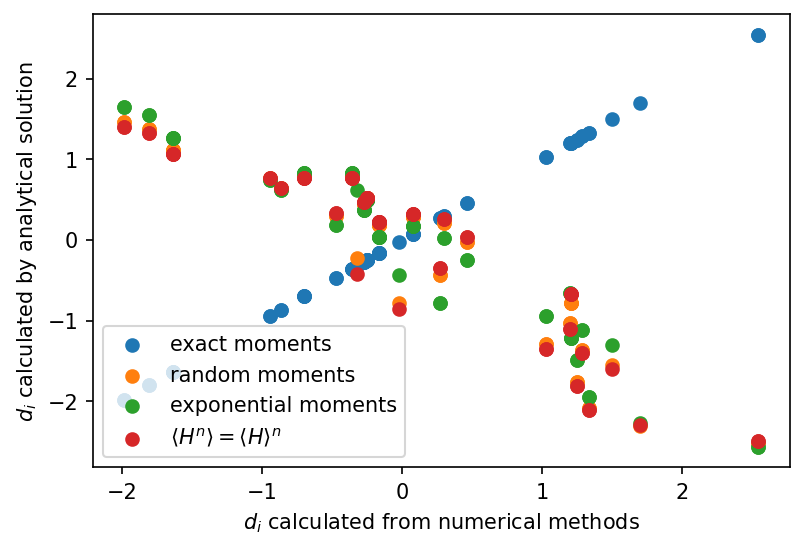

In [32]:
plt.scatter(numerical_importances_scaled, pauli_importances_scaled,label="exact moments")
plt.scatter(numerical_importances_scaled, random_importances_scaled,label="random moments")
plt.scatter(numerical_importances_scaled, exponential_importances_scaled,label="exponential moments")
plt.scatter(numerical_importances_scaled, hn_importances_scaled,label=r"$\langle H^n \rangle = \langle H \rangle^n$")
plt.xlabel("$d_i$ calculated from numerical methods")
plt.ylabel("$d_i$ calculated by analytical solution")
plt.legend()

In [33]:
strategies_mse_dict["<H^n> = <H>^n"] = strategy_mse(hn_importances_scaled)

In [34]:
strategies_mse_dict

{'exact': 0.0001,
 'random': 1.5473,
 'exponential': 1.547,
 '<H^n> = <H>^n': 1.5445}

Unfortunately, this does even worse.

<h1> Step 7) A weighted average of the exponential </h1>
    
I was messing around with the exponential approximation and thought of this idea. Basically, what happens if we take our exponential approximation and mix it with the exact moments? Weird things happen. I will call the mixing coeffient $r$.

In [35]:
def weighted_moments(dict1, dict2, r):
    dict_ = {i: 0.5*(r*dict1[i] + (1-r)*dict2[i]) for i in dict1}
    return dict_
def mse_from_r(r):
    dict1 = exponential_moments
    dict2 = exact_moments
    wdict = weighted_moments(dict1, dict2, r)
    wdict_paulis = pauli_importances_from_moments(wdict)
    wscaled = scale_data(list(wdict_paulis.values()))
    return strategy_mse(wscaled)

In [36]:
rs = np.linspace(0,1,100)
mses_r = [mse_from_r(i) for i in rs]

Text(0, 0.5, 'mse(r) (mse wrt r)')

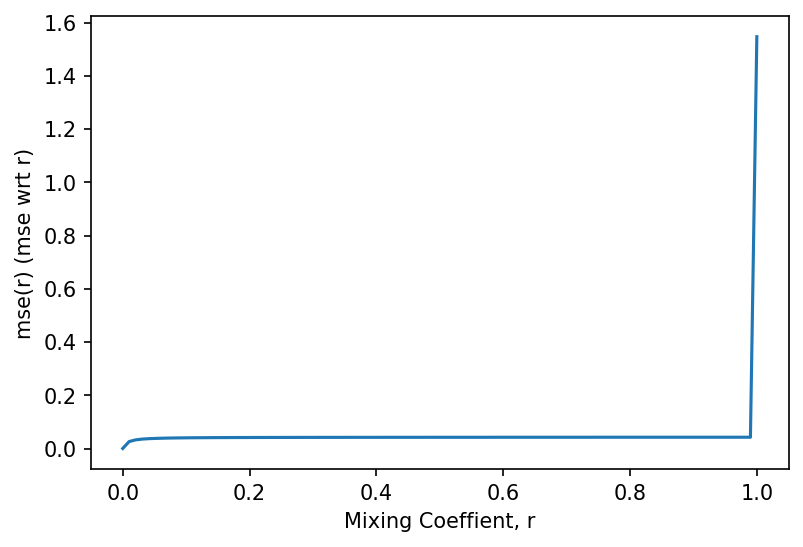

In [37]:
plt.plot(rs, mses_r)
plt.xlabel("Mixing Coeffient, r")
plt.ylabel("mse(r) (mse wrt r)")

I find this plot astounding because even when the mixing coefficient is almost 1, the exponential strategy does well. However, it shoots up to a large mse right when the mixing coefficient approachs 1.

In [38]:
weighted_exponential_moments = weighted_moments(exponential_moments, exact_moments, 0.999)
weighted_importances = pauli_importances_from_moments(weighted_exponential_moments)
weighted_exponential_scaled = scale_data(list(weighted_importances.values()))

/home/jaulicino/anaconda3/envs/QML_env/lib/python3.9/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


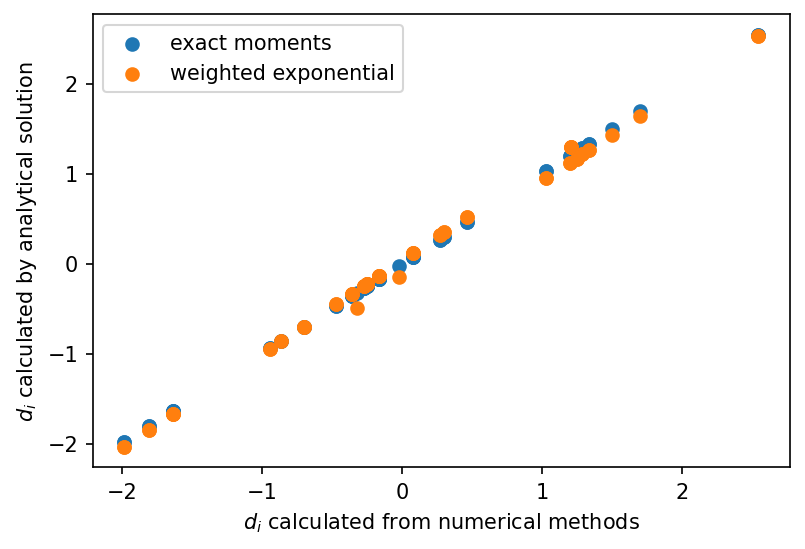

In [39]:
plt.scatter(numerical_importances_scaled, pauli_importances_scaled,label="exact moments")
plt.scatter(numerical_importances_scaled, weighted_exponential_scaled,label=r"weighted exponential")
plt.xlabel("$d_i$ calculated from numerical methods")
plt.ylabel("$d_i$ calculated by analytical solution")
plt.legend()

In [41]:
strategies_mse_dict["weighted exponential"] = strategy_mse(weighted_exponential_scaled)

In [42]:
strategies_mse_dict

{'exact': 0.0001,
 'random': 1.5473,
 'exponential': 1.547,
 '<H^n> = <H>^n': 1.5445,
 'weighted exponential': 0.0424}

Somehow, the weighted average does extremely well, even though it $r = 0.999$